In [2]:
import os
import seaborn as sns
import pandas as pd
import geopandas as gpd
import re, io, numpy as np
from cStringIO import StringIO 
from pandas.api.types import CategoricalDtype

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)  #DEBUG, INFO, WARNING, ERROR, CRITICAL

%pylab inline
# Get current size
fig_size = plt.rcParams["figure.figsize"]
print "Current size:", fig_size
# Set figure width to 12 and height to 9
fig_size[0] = 10
fig_size[1] = 6.5
plt.rcParams["figure.figsize"] = fig_size
print "Current size:", fig_size
plt.rcParams['figure.figsize']
plt.style.use('ggplot')

drop=os.getenv('DROPBOX_LOC')
box=os.getenv('BOX_LOC')

Populating the interactive namespace from numpy and matplotlib
Current size: [6.0, 4.0]
Current size: [10, 6.5]


In [50]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

def comma_format(x, p):
    return format(x, "6,.0f").replace(",", ".")
def percent_format(x, p):
    return format(x, "6,.02f").replace(",", ".")

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

In [51]:
def easer(target_series=target_series,source_series=source_series,
          t_0=7,t_1=15,envelope_year_start=2015,envelope_year_end=2050):
    """Takes a source series (keyed on year) and transitions to a target series over a period of time.
    
    """
    
    ## We 'ease out' the difference between the series of interest and the target series
    ## when the easing out of the difference is done (difference is 0) the two are identical 
    
    # x-coordinates
    index = np.arange(envelope_year_end-envelope_year_start+1)

    easing_window = (t_1 - t_0)

    # Use a sinusoidal easing function, set to converge in a relevant range between t_0 and t_1
    x = np.pi * (index - t_0) / easing_window
    easing = 0.5 * np.cos(x) + 0.5

    # To the left of the convergence window, easing should be 1 (i.e. = source series)
    easing[index < t_0] = 1

    # To the right of the convergence window, it should be 0 (i.e. no difference to,
    ## or fully transitioned to target series)
    
    easing[index >= t_1] = 0

    # turn in to a pd.Series
    easing = pd.Series(easing,index=np.arange(envelope_year_start,envelope_year_end+1))
    easing.index=easing.index.set_names('Year')

    source_less_target=source_series-target_series
    output=(source_less_target.mul(easing,axis=0)+target_series).stack(level=[0,1])
    output.index=output.index.set_names('year',0)
    output.name='value'
    return output

In [52]:
# e1=easer(target_series=target_series,source_series=source_series,
#                envelope_year_start=2015,envelope_year_end=2050,
#                t_0=9,t_1=23)

In [53]:
# easer(target_series=target_series,source_series=source_series,
#                envelope_year_start=2015,envelope_year_end=2050,
#                t_0=9,t_1=23)

In [54]:
bayareafips ={'06001':'ala', '06013':'con', '06041':'mar', '06055':'nap', '06075':'sfr', '06081':'san', '06085':'scl', '06097':'son', '06095':'sol'}

In [8]:
puma2000 = pd.read_csv(os.path.join(drop,'Documents/Data/GIS/Census/PUMAs/2000/us_pumas_2000_nowater_county.csv'),dtype=object)
puma2000.rename(columns = {'PUMA5ID00':'STPUMA','COUNTYFIPS':'STCOUNTY'},inplace=True)
puma_x_county=puma2000.groupby(['STPUMA']).STCOUNTY.first()

## Get Census 2000 data

### Data is in fixed with, delimited files.
We load the record layout to generate the column width definitions for household, person records in turn.

In [9]:
layout = pd.ExcelFile(os.path.join(drop,'Documents/Data/_Census/lookups/5%_PUMS_record_layout.xls'))
personsfile = layout.parse('Person Record',skiprows=1)
housingfile = layout.parse('Housing Unit Record',skiprows=1)
personsfile.head()

,RT,BEG,END,LEN,A/N,VARIABLE,DESCRIPTION,LO,HI,VALUE DESCRIPTION,LO.1,HI.1,VALUE DESCRIPTION.1,EXPLANATORY NOTE,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P,1,1,1,A,RECTYPE,Record Type,P,NaN,Person record,P,NaN,Person record,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P,2,8,7,A,SERIALNO,Housing/Group Quarters (GQ) Unit Serial Number,0000001,9999999,Unique identifier assigned within state,0000001,9999999,Unique identifier assigned within state,SERIALNO is common for each unit and all perso...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
personsfile=personsfile.ix[(personsfile.RT.notnull()) & (personsfile.BEG.notnull())]
personsfile['BEG']=personsfile.BEG.apply(lambda x: np.nan if str(x).strip()=='' else str(x).strip())#.astype(np.int64)
personsfile=personsfile[personsfile.BEG.notnull()]
personsfile['BEG']=personsfile['BEG'].astype(np.int64)#-1
personsfile=personsfile.groupby(['RT','BEG','END','VARIABLE','DESCRIPTION']).size().reset_index(name='value')
personsfile=personsfile.loc[~personsfile.DESCRIPTION.str.contains('1% file')]
personsfile.head()

/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,RT,BEG,END,VARIABLE,DESCRIPTION,value
0,P,1,1,RECTYPE,Record Type,1
1,P,2,8,SERIALNO,Housing/Group Quarters (GQ) Unit Serial Number,1
2,P,9,10,PNUM,Person Sequence Number,1
3,P,11,11,PAUG,Augmented Person Flag,2
4,P,12,12,DDP,Data-defined Person Flag,3


In [11]:
persons_names = personsfile.VARIABLE.str.strip().tolist()

In [12]:
housingfile=housingfile.ix[(housingfile.RT.notnull()) & (housingfile.BEG.notnull())]
housingfile['BEG']=housingfile.BEG.apply(lambda x: np.nan if str(x).strip()=='' else str(x).strip())#.astype(np.int64)
housingfile=housingfile.ix[(housingfile.BEG.notnull()) & (housingfile.BEG!='nan')]
housingfile['BEG']=housingfile['BEG'].astype(np.int64)#-1
housingfile=housingfile.groupby(['RT','BEG','END','VARIABLE','DESCRIPTION']).size().reset_index(name='value')
housingfile=housingfile.loc[~housingfile.DESCRIPTION.str.contains('1% file')]
housingfile.head()

/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,RT,BEG,END,VARIABLE,DESCRIPTION,value
0,H,1,1,RECTYPE,Record Type,1
1,H,2,8,SERIALNO,Housing/Group Quarters (GQ) Unit Serial Number,1
2,H,9,9,SAMPLE,Sample Identifier,1
3,H,10,11,STATE,State Code,2
4,H,12,12,REGION,Region Code,5


In [13]:
housing_names = housingfile.VARIABLE.str.strip().tolist()

In [14]:
persons_coldefs = personsfile.apply(lambda x: (int(x.BEG)-1,int(x.END)),axis=1).tolist()
housing_coldefs = housingfile.apply(lambda x: (int(x.BEG)-1,int(x.END)),axis=1).tolist()


In [15]:
#census2000pca = pd.read_fwf(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/REVISEDPUMS5_06.TXT'),colspecs=persons_coldefs,names=persons_names )

### The raw files have both p and h records. Parse separately to different dataframes
Data is for all of California, and it is a 15 percent sample. It is large, so run in chunks.

In [16]:
%%time

if not os.path.exists(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/census2000pca.csv')):
    
    ## Households and persons stored separately

    #census2000hca = pd.read_fwf(r'N:\Planning\ABAG Data Library\DataRepository\_CensusData\Census 2000\PUMS\PUMS5_06.TXT',colspecs=housing_coldefs,names=housing_names )

    pstore=[]
    hstore=[]

    i=0

    for chunk in pd.read_fwf(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/REVISEDPUMS5_06.TXT'),
                             colspecs=housing_coldefs,names=housing_names, chunksize=250000):
            print i,
            chunk_p=chunk.loc[chunk.RECTYPE=='P']
            chunk_h=chunk.loc[chunk.RECTYPE=='H']
            pstore.append(chunk_p)
            hstore.append(chunk_h)
            i+=1
    census2000hca=pd.concat(hstore)
    census2000pca=pd.concat(pstore)
    
    census2000pca[census2000pca.STCOUNTY.isin(bayareafips)].to_csv(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/census2000pca.csv'))
    census2000hca[census2000hca.STCOUNTY.isin(bayareafips)].to_csv(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/census2000hca.csv'))
    
else:
    census2000pca=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/census2000pca.csv'))
    census2000hca=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/census2000hca.csv'))

CPU times: user 7.11 s, sys: 852 ms, total: 7.96 s
Wall time: 9.31 s


In [17]:
#pd.read_fwf(os.path.join(drop,'Documents/Data/_Census/PUMS/Decennial/2000/REVISEDPUMS5_06.TXT'),colspecs=housing_coldefs,names=housing_names)

In [18]:
census2000hca['STPUMA']=census2000hca['PUMA5'].apply(lambda x: '06{:05d}'.format(x))
census2000hca['STCOUNTY']=census2000hca.STPUMA.map(puma_x_county)
census2000pca['STCOUNTY']=census2000pca.SERIALNO.map(census2000hca.groupby('SERIALNO').STCOUNTY.first())

### Recoding

Here's the mapping per the census 2000 sf3 docs:

> 1  .  White alone
> 2  .  Black or African American alone
> 3  .  American Indian alone
> 4  .  Alaska Native alone
> 5  .  American Indian and Alaska Native tribesspecified, and American Indian or AlaskaNative, not specified, and no other races
> 6  .  Asian alone
> 7  .  Native Hawaiian and Other Pacific Islanderalone
> 8  .  Some other race alone
> 9  .  Two or more major race group

In [32]:
## REMI doesn't have much race detail, so we don't either.

codesraceREMI ="""
1 .White
2 .Black
3 .Other
4 .Other
5 .Other
6 .Other
7 .Other
8 .Other
9 .Other
"""

In [33]:
regiontype_gen={'06001': 'Bay Area',
 '06013': 'Bay Area',
 '06017': 'Rest of CA',
 '06033':'Rest of CA',
 '06045':'Rest of CA',
 '06041': 'Bay Area',
 '06047': 'Rest of CA',
 '06053': 'Rest of CA',
 '06055': 'Bay Area',
 '06061': 'Rest of CA',
 '06067': 'Rest of CA',
 '06069': 'Rest of CA',
 '06075': 'Bay Area',
 '06077': 'Rest of CA',
                '06073':'SANDAG',
 '06081': 'Bay Area',
 '06085': 'Bay Area',
 '06087': 'Rest of CA',
 '06095': 'Bay Area',
 '06097': 'Bay Area',
 '06099': 'Rest of CA',
 '06101': 'Rest of CA',
 '06113': 'Rest of CA',
 '06115': 'Rest of CA',
                 '06025': 'SCAG',  # imperial
 '06037': 'SCAG',   # LA
 '06071': 'SCAG',  # san bernadino
 '06059': 'SCAG',  # orange
 '06065': 'SCAG',  # riverside
 '06011': 'SCAG', # ventura
 'outside': 'outside',
               u'13057': u'Atlanta Regional',
 u'13063': u'Atlanta Regional',
 u'13067': u'Atlanta Regional',
 u'13089': u'Atlanta Regional',
 u'13097': u'Atlanta Regional',
 u'13113': u'Atlanta Regional',
 u'13121': u'Atlanta Regional',
 u'13135': u'Atlanta Regional',
 u'13151': u'Atlanta Regional',
 u'13247': u'Atlanta Regional'}

In [34]:
def race_eth(df):
    if df.name>1:
        return 'Hispanic'
    else:
        return df+'-NonHispanic'
    

In [35]:
from cStringIO import StringIO 
def map_value_labels(codes_pasted,var):
    """
    Reads pasted id:value correspondence and prepares a 
    id:value dictionary to be used for mapping
    """
    
    ## substitute out dots and leading space
    codes_pasted = re.sub(r' \.','\t', codes_pasted)
    
    ## read code string as if it were a file object, store in dataframe
    df_codes = pd.read_csv(StringIO(codes_pasted), 
                           encoding='utf8', sep="\t",
                           header=None if os.name=='posix' else None,
                           names=['id','value'],
                           dtype={'id': object, 'value': object})
    
    df_codes['value']=df_codes['value'].apply(lambda x: str(x).strip())
    
    df_codes.index=df_codes.id.astype(np.int64)
    df_codes=df_codes['value'].to_dict()
    #print df_codes
    ## store output in a dict keyed on the variable name, with the codes being the values
    d={}
    d[var]=df_codes
    return d


In [36]:
def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("age{fr:02.0f}{to:02.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='age{dt:,.0f}p'.format(dt=breaks[-2])
    return labels
def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

diffbreaks_5 =range(0,86,5)+[np.inf]
diffbreaks_custom =[0,18,25,45,65,np.inf]
seniors=agebreaker2(diffbreaks_5)[-5:]

In [37]:
census2000pca['race_remi']=census2000pca.RACE1.map(map_value_labels(codesraceREMI,'RAC1P')['RAC1P'])
census2000pca['age_grp_5']=pd.cut(census2000pca.AGE, right=False,bins=diffbreaks_5,labels=agebreaker2(diffbreaks_5)).astype(str)
census2000pca['rac_ethn']=census2000pca.groupby(['HISPAN'])['race_remi'].transform(race_eth)
census2000pca['region']=census2000pca.STCOUNTY.map(regiontype_gen).fillna('Rest of CA')

In [38]:
hhgrp=['region','rac_ethn','age_grp_5']

In [39]:
## numerator - householDERS
numerator=census2000pca.loc[(census2000pca.RELATE==1)].groupby(hhgrp).PWEIGHT.sum()
numerator.head()

region    rac_ethn           age_grp_5 
Bay Area  Black-NonHispanic  Ages 15-19      899
                             Ages 20-24     6749
                             Ages 25-29    13065
                             Ages 30-34    17905
                             Ages 35-39    22316
Name: PWEIGHT, dtype: int64

In [40]:
## denominator - household pop
denominator=census2000pca.loc[(~census2000pca.RELATE.isin([22,23]))].groupby(hhgrp).PWEIGHT.sum()
denominator.head()

region    rac_ethn           age_grp_5 
Bay Area  Black-NonHispanic  Ages 0-4      32323
                             Ages 10-14    39255
                             Ages 15-19    33525
                             Ages 20-24    29072
                             Ages 25-29    30337
Name: PWEIGHT, dtype: int64

In [41]:
headship2k=numerator/denominator
headship2k=headship2k.fillna(0)

### Merge with conteporary headship rates for the same regions, prepared in separate notebook

In [42]:
## first one is acs 12-16
## deprecated - load a CSV that has several already bundled
#headship_ACS_12_16=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions.csv'),index_col=[u'region', u'rac_ethn', u'age_grp_5']).value.fillna(0)
#headship_ACS_14_18=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions_2014_2018.csv'),index_col=[u'region', u'rac_ethn', u'age_grp_5']).value.fillna(0)
#headship_ACS_18=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions_2018.csv'),index_col=[u'region', u'rac_ethn', u'age_grp_5']).value.fillna(0)

headship_ACS_MULTI=pd.read_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions_multiyear.csv'),index_col=[u'VINTAGE','region', u'rac_ethn', u'age_grp_5']).value.fillna(0)
headship_ACS_MULTI.head()

VINTAGE  region    rac_ethn           age_grp_5 
ACS 12   Bay Area  Black-NonHispanic  Ages 0-4      0.000000
                                      Ages 10-14    0.000000
                                      Ages 15-19    0.013822
                                      Ages 20-24    0.169653
                                      Ages 25-29    0.352283
Name: value, dtype: float64

In [43]:
(headship_ACS_MULTI.loc['ACS 18'].loc['Bay Area',:,seniors]/headship_ACS_MULTI.loc['ACS 14-18'].loc['Bay Area',:,seniors]).unstack(2)

age_grp_5                   Ages 65-69  Ages 70-74  Ages 75-79  Ages 80-84  \
region   rac_ethn                                                            
Bay Area Black-NonHispanic    0.913407    1.013386    0.970031    0.938902   
         Hispanic             1.038945    0.995957    0.960689    1.004451   
         Other-NonHispanic    1.061065    0.958191    1.070938    1.053219   
         White-NonHispanic    0.991385    0.992436    0.985963    1.014906   

age_grp_5                   Ages 85+  
region   rac_ethn                     
Bay Area Black-NonHispanic  0.979592  
         Hispanic           0.984811  
         Other-NonHispanic  0.879906  
         White-NonHispanic  0.989428

In [44]:
# headship_combo_df=pd.concat([headship2k,
#                              headship_ACS_12_16,
#                              headship_ACS_14_18,
#                             headship_ACS_18],keys=['Census 2000','ACS 12-16','ACS 14-18','ACS 18'],
#                             names=['vintage']).reset_index(name='value')
# headship_combo_df.age_grp_5=headship_combo_df.age_grp_5.astype(CategoricalDtype(categories=agebreaker2(diffbreaks_5),ordered=True))


In [45]:
headship_combo_df=pd.concat([pd.concat([headship2k],keys=['Census 2000'],names=['VINTAGE']),
                             headship_ACS_MULTI]
                            
                            ).reset_index(name='value')
headship_combo_df.columns=headship_combo_df.columns.str.lower()
headship_combo_df.age_grp_5=headship_combo_df.age_grp_5.astype(CategoricalDtype(categories=agebreaker2(diffbreaks_5),ordered=True))
headship_combo_df

,vintage,region,rac_ethn,age_grp_5,value
0,Census 2000,Bay Area,Black-NonHispanic,Ages 0-4,0.000000
1,Census 2000,Bay Area,Black-NonHispanic,Ages 10-14,0.000000
2,Census 2000,Bay Area,Black-NonHispanic,Ages 15-19,0.026816
3,Census 2000,Bay Area,Black-NonHispanic,Ages 20-24,0.232148
4,Census 2000,Bay Area,Black-NonHispanic,Ages 25-29,0.430662
5,Census 2000,Bay Area,Black-NonHispanic,Ages 30-34,0.512758
6,Census 2000,Bay Area,Black-NonHispanic,Ages 35-39,0.557663
7,Census 2000,Bay Area,Black-NonHispanic,Ages 40-44,0.584906
8,Census 2000,Bay Area,Black-NonHispanic,Ages 45-49,0.602723
9,Census 2000,Bay Area,Black-NonHispanic,Ages 5-9,0.000000


In [46]:
headship_combo_df.to_csv(os.path.join(drop,'Data/PBA2050/headship_stateregions_vintages.csv'))

In [47]:
headship_combo=headship_combo_df.set_index(['vintage','region','rac_ethn','age_grp_5']).value.sort_index()
headship_combo=headship_combo.loc[:,:,:,agebreaker2(diffbreaks_5)[3:]]

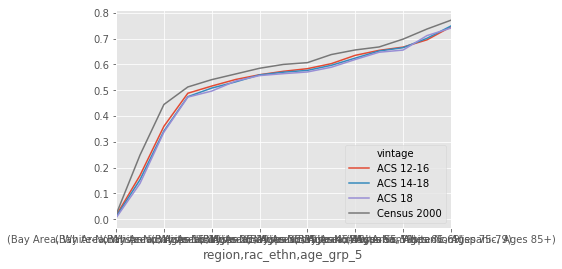

In [48]:
headship_combo.loc[['Census 2000','ACS 14-18','ACS 12-16','ACS 18'],'Bay Area'].unstack(0).loc(0)[:,'White-NonHispanic'].plot()

## Phase rates from *more* restrictive rates to *less* restrictive ones
Perhaps surprisingly, headship rates tended to be higher for most subgroups in 2000 relative to now. We create a transition dataframe that starts with the tight rates as of 2018, and relax them over a 15 year time frame to 2000 rates, consistent with a housing market that is less expensive.

In [55]:
HR_START='ACS 18'
HR_START='ACS 14-18'

HR_END='Census 2000'

envelope_year_start=2015
envelope_year_end=2050

source_series={}
for yr in range(2015,2051):
    source_series[yr]=headship_combo.loc[HR_START,'Bay Area']
source_series=pd.concat(source_series,names=['Year']).unstack(level=['rac_ethn','age_grp_5'])

target_series={}
for yr in range(2015,2051):
    target_series[yr]=headship_combo.loc[HR_END,'Bay Area']
target_series=pd.concat(target_series,names=['Year']).unstack(level=['rac_ethn','age_grp_5'])

hr_eased=easer(target_series=target_series,source_series=source_series,
               envelope_year_start=2015,envelope_year_end=2050,
               t_0=9,t_1=23)
hr_eased.index=hr_eased.index.set_names('Year',0)
#hr_eased.reset_index(name='value').to_csv(os.path.join(drop,'Data/PBA2050/headship_acs18_1_to_c2000.csv'))
hr_eased.reset_index(name='value').to_csv(os.path.join(drop,'Data/PBA2050/headship_combo_eased.csv'))

In [56]:
hr_eased.loc[:,'White-NonHispanic'].unstack(1)

age_grp_5,Ages 15-19,Ages 20-24,Ages 25-29,Ages 30-34,Ages 35-39,Ages 40-44,Ages 45-49,Ages 50-54,Ages 55-59,Ages 60-64,Ages 65-69,Ages 70-74,Ages 75-79,Ages 80-84,Ages 85+
Year,,,,,,,,,,,,,,,
2015,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2016,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2017,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2018,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2019,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2020,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2021,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2022,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554
2023,0.009987,0.153220,0.342035,0.474900,0.508238,0.532306,0.559316,0.569824,0.576831,0.596426,0.624253,0.652027,0.664775,0.701046,0.748554


Text(0.5,1,'Illustration of age-specific phasing, here for White-Non-hispanic')

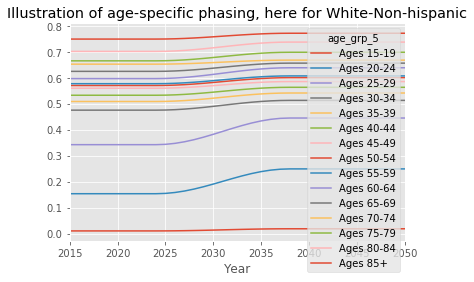

In [57]:
hr_eased.loc[:,'White-NonHispanic'].unstack(1).plot()
title('Illustration of age-specific phasing, here for White-Non-hispanic')

In [58]:
# headship_evolved={}
# START_YEAR=2022
# TIME_PERIOD=10

# HR_START='ACS 18'
# HR_END='Census 2000'

# ## yearly shift from 2000-2016 rates - we could assume that the two would converge after, say, 10  years
# yrs=[]
# gradual_headship_shift=(headship_combo.loc[:,'Bay Area'].unstack(0).diff(axis=1)/TIME_PERIOD)[HR_END]

# for step in range(TIME_PERIOD): #'22-'32'
#     headship_evolved[START_YEAR+step]=headship_combo.loc[HR_START,'Bay Area']+gradual_headship_shift*step
#     yrs.append(START_YEAR+step)
# ## post-phasing
# for yr in range(START_YEAR+TIME_PERIOD,2051):
#     headship_evolved[yr]=headship_combo.loc[HR_START,'Bay Area']+gradual_headship_shift*step
#     yrs.append(yr)
# ## pre-phasing
# for yr in range(2015,START_YEAR):
#     headship_evolved[yr]=headship_combo.loc[HR_START,'Bay Area']#+gradual_headship_shift*step
#     yrs.append(yr)
    
# pd.concat(headship_evolved,names=['Year'])#.reset_index(name='value').to_csv(os.path.join(drop,'Data/PBA2050/headship_acs18_1_to_c2000.csv'))

In [78]:
headship_combo.loc[['Census 2000','ACS 14-18'],['Bay Area','SCAG'],'Black-NonHispanic'].unstack([1,0]).sort_index(axis=1)

region                        Bay Area                  SCAG
vintage                      ACS 14-18 Census 2000 ACS 14-18
rac_ethn          age_grp_5                                 
Black-NonHispanic Ages 15-19  0.020010    0.026816  0.016811
                  Ages 20-24  0.141799    0.232148  0.130133
                  Ages 25-29  0.322645    0.430662  0.299324
                  Ages 30-34  0.400196    0.512758  0.452117
                  Ages 35-39  0.483497    0.557663  0.500491
                  Ages 40-44  0.535070    0.584906  0.568368
                  Ages 45-49  0.555552    0.602723  0.583029
                  Ages 50-54  0.611041    0.645124  0.591282
                  Ages 55-59  0.582187    0.649995  0.621526
                  Ages 60-64  0.641168    0.690397  0.623993
                  Ages 65-69  0.671401    0.697340  0.673747
                  Ages 70-74  0.738098    0.747898  0.664874
                  Ages 75-79  0.724215    0.746123  0.690257
                  Ages 80-84  0.663478    0.726182  0.677280
                  Ages 85+    0.677969    0.701923  0.660352

### Check variation in rates - here for 'white-non-hispanic'

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

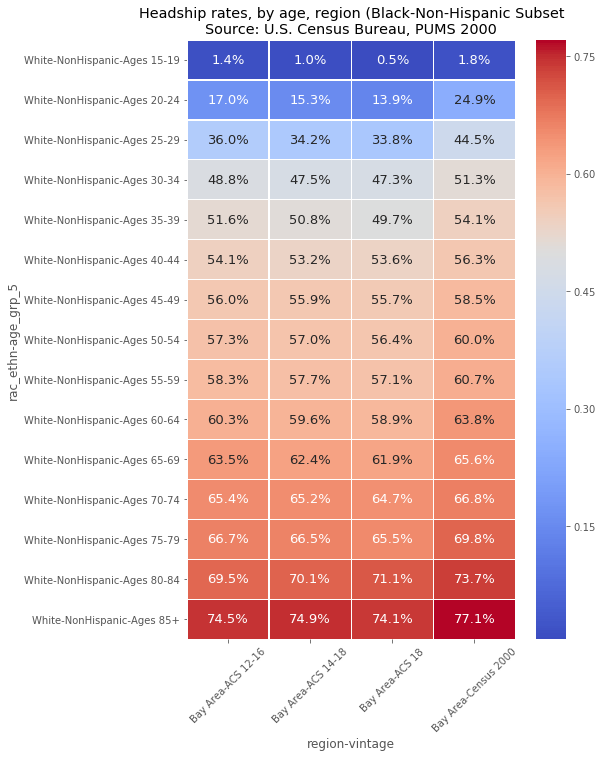

In [75]:
fmt_abs = lambda x,pos: '{:,.2f}'.format(x)

fig, ax = plt.subplots()
fig.set_figwidth(8.5)
fig.set_figheight(11)        
ax=sns.heatmap(headship_combo.loc[['Census 2000','ACS 12-16','ACS 14-18','ACS 18'],['Bay Area'],
                                  'White-NonHispanic'
                                 ].unstack([1,0]).sort_index(axis=1).fillna(0),
             annot=True, fmt='.1%',annot_kws={"size": 13.1,'rotation':0},linewidths=.5,
              cbar_kws={'format': FuncFormatter(fmt_abs)},
               cmap=cm.coolwarm,norm=MidpointNormalize(midpoint=.5));
title('Headship rates, by age, region (Black-Non-Hispanic Subset\nSource: U.S. Census Bureau, PUMS 2000')
plt.tight_layout()
plt.xticks(rotation=45)
#savefig('C:/Users/aolsen/Box Sync/Horizon and Plan Bay Area 2050/Perspective Papers/05_Future of Work/presentations/misc charts/jobs_by_vmt_quintile_2002_2015_change.pdf')

In [79]:
headship_combo.loc[['Census 2000','ACS 12-16','ACS 14-18','ACS 18'],['Bay Area'],
                                  'White-NonHispanic'
                                 ].unstack([1,0]).sort_index(axis=1).fillna(0)

region                        Bay Area                                
vintage                      ACS 12-16 ACS 14-18    ACS 18 Census 2000
rac_ethn          age_grp_5                                           
White-NonHispanic Ages 15-19  0.014043  0.009987  0.005330    0.018223
                  Ages 20-24  0.169837  0.153220  0.138808    0.248742
                  Ages 25-29  0.360216  0.342035  0.337582    0.444630
                  Ages 30-34  0.488212  0.474900  0.473256    0.512522
                  Ages 35-39  0.516088  0.508238  0.496612    0.540932
                  Ages 40-44  0.541499  0.532306  0.535542    0.562907
                  Ages 45-49  0.559933  0.559316  0.556596    0.584949
                  Ages 50-54  0.573301  0.569824  0.564117    0.599936
                  Ages 55-59  0.583445  0.576831  0.570618    0.606728
                  Ages 60-64  0.602806  0.596426  0.588937    0.638125
                  Ages 65-69  0.635074  0.624253  0.618875    0.655935
                  Ages 70-74  0.654410  0.652027  0.647095    0.667534
                  Ages 75-79  0.666899  0.664775  0.655443    0.697786
                  Ages 80-84  0.695136  0.701046  0.711495    0.736954
                  Ages 85+    0.745474  0.748554  0.740640    0.770999

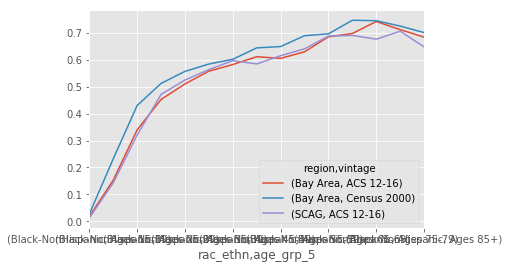

In [80]:
headship_combo.loc[['Census 2000','ACS 12-16'],['Bay Area','SCAG'],'Black-NonHispanic'].unstack([1,0]).sort_index(axis=1).plot()

In [81]:
HCD_headship=pd.read_clipboard(names=['age_grp_10','rate'])

In [82]:
HCD_headship

,,,,age_grp_10,rate
Year,Draft Blueprint,Blueprint Baseline,DOF B2019,DOF B2019 UPPER,DOF B2019 LOWER
2005,6817678.0,6817678.0,NaN,NaN,NaN
2006,6844896.0,6844896.0,NaN,NaN,NaN
2007,6903889.0,6903889.0,NaN,NaN,NaN
2008,7001041.0,7001041.0,NaN,NaN,NaN
2009,7093016.0,7093016.0,NaN,NaN,NaN
2010,7167026.0,7167026.0,7177970.0,NaN,NaN
2011,7255420.0,7255420.0,7263668.0,NaN,NaN
2012,7354912.0,7354912.0,7359086.0,NaN,NaN
2013,7459008.0,7459008.0,7447942.0,NaN,NaN
